In [1]:
import os
import numpy as np
import matplotlib
import torch
# !pip install mat73
# import mat73
import matplotlib.pyplot as plt
import csv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split,TensorDataset
from torchvision import transforms, utils
import time
import pandas as pd
import scipy.io
import sklearn.metrics
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

from scipy import signal

from sklearn.metrics import confusion_matrix

import seaborn as sn
import pandas as pd

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import LeaveOneGroupOut






In [2]:
from math import sqrt
import torch
import torch.nn.functional as F
from torch import nn
!pip install einops
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class LSA(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.temperature = nn.Parameter(torch.log(torch.tensor(dim_head ** -0.5)))

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.temperature.exp()

        mask = torch.eye(dots.shape[-1], device = dots.device, dtype = torch.bool)
        mask_value = -torch.finfo(dots.dtype).max
        dots = dots.masked_fill(mask, mask_value)

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, LSA(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class SPT(nn.Module):
    def __init__(self, *, dim, patch_size, channels = 3):
        super().__init__()
        patch_dim = patch_size * patch_size * 5 * channels

        self.to_patch_tokens = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim)
        )

    def forward(self, x):
        shifts = ((1, -1, 0, 0), (-1, 1, 0, 0), (0, 0, 1, -1), (0, 0, -1, 1))
        shifted_x = list(map(lambda shift: F.pad(x, shift), shifts))
        x_with_shifts = torch.cat((x, *shifted_x), dim = 1)
        return self.to_patch_tokens(x_with_shifts)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = SPT(dim = dim, patch_size = patch_size, channels = channels)

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [3]:
FiltName='filt_0.1_5'
file_name_data=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/data_all_per8_multi6_filt_0.1_5.npz"
data=np.load(file_name_data)

feature_stft_per=data['feature_stft_per']
feature_stft2_per=data['feature_stft2_per']

feature_cwt_per=data['feature_cwt_per']
feature_cwt2_per=data['feature_cwt2_per']
feature_cwt3_per=data['feature_cwt3_per']

label_all_per=data['label_all_per']
caseNum_all_per=data['caseNum_all_per']
perNum_all_per=data['perNum_all_per']

data=[]

In [ ]:
in_ch=48
num_class=23
self_channel=[0,1,10,11,20,21,30,31]
par_vit={'dim':512,'depth':6,'heads':16,'mlp_dim':32,'dropout':0.1,'emb_dropout':0.1,'n_epoch':15,'learning_rate':1e-5};

modelVer='v1_per8'

def gen_trans_model(X_all,y_all,opt,per_test,FeatType):
  import torch
  torch.cuda.empty_cache()

  if __name__ == '__main__':
      
      transform = ToTensor()
      batchsize_train = 16

      # folds=RepeatedStratifiedKFold(n_splits=5, n_repeats=1,random_state=100).split(X_all,y_all)
      # folds=StratifiedGroupKFold(n_splits=7).split(X_all,y_all,perNum_all_per) 
      # test_ind_all=[]
      # train_ind_all=[]
      # for train_index, test_index in folds:
      #   test_ind_all.append(test_index)
      #   train_ind_all.append(train_index)
      # n_sel=2
      
      tst_ind=np.where(perNum_all_per==per_test)[0]
      trn_ind=np.where(perNum_all_per!=per_test)[0]

      X_train=X_all[trn_ind] 
      X_test=X_all[tst_ind]
      y_train=y_all[trn_ind] 
      y_test=y_all[tst_ind]

      train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), batch_size=batchsize_train,shuffle=True)
      batchsize_test = 16
      test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), batch_size=batchsize_test, shuffle=False)


      (unique, counts) = np.unique(perNum_all_per[trn_ind], return_counts=True)
      frequencies = np.asarray((unique, counts)).T
      print(frequencies)
      (unique, counts) = np.unique(perNum_all_per[tst_ind], return_counts=True)
      frequencies = np.asarray((unique, counts)).T
      print(frequencies)
      #hyperparameter definition    
      learning_rate = par_vit['learning_rate']  #学习的速率 越小越精细
      momentum = 0.1
      random_seed=1
      torch.backends.cudnn.enabled = False
      torch.manual_seed(random_seed)     #设定随机数种子为固定值
      
      train_loss_epoch = []
      test_acc_epoch =[]
      total_acc_epoch = []
      

   

      network = ViT(
      image_size = opt['image_size'],
      patch_size = opt['patch_size'],
      num_classes =num_class,
      dim = par_vit['dim'],
      depth = par_vit['depth'],
      heads = par_vit['heads'],
      mlp_dim = par_vit['mlp_dim'],
      dropout = par_vit['dropout'],
      emb_dropout = par_vit['emb_dropout'],
      channels = in_ch
      ).cuda()
   
      #training
      optimizer = optim.Adam(network.parameters(), lr=learning_rate)
      #optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
      

      #network.train()
      Training_Loss = []
      Test_Loss = []
      start_time = time.time()
      criterion = nn.CrossEntropyLoss()
      #criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1, 3]).cuda())
      for epoch in range(par_vit['n_epoch']):   # loop over the dataset multiple times
          train_loss = 0
          for X, Y in train_loader:
              # X = X.view(-1,1,X.shape[2],X.shape[3]).cuda()
              X = X.float().cuda()  
              Y = Y.long().view(-1, ).cuda() 
              current_batchsize = X.shape[0]
              optimizer.zero_grad()
              output = network(X)
              loss = criterion(output,Y)
              train_loss = train_loss + loss.item()
              loss.backward()                     #calculate the gradient decent
              optimizer.step()                    #update the weight
              
            





          test_loss = 0
          correct = 0
          total = 0
          test_y= []
          test_y_p = []
     
          with torch.no_grad():        
              # X = X.view(-1,X.shape[1],X.shape[2])
              # X = X.float()         
              for X, Y in test_loader:
                  X = torch.Tensor(X).cuda()
                  Y = torch.Tensor(Y).long().view(-1, ).cuda()
                  images, labels = X, Y
                  # calculate outputs by running images through the network
                  outputs = network(images)
                  loss = criterion(outputs,Y)
                  test_loss = test_loss + loss.item()

                  # the class with the highest energy is what we choose as prediction
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()
                  
                  for i in range(len(labels)):
                    test_y.append(labels[i])
                    test_y_p.append(predicted[i])
          
          #print('Accuracy of test cases: %d %%' % (100 * correct / total))
  

          Training_Loss.append(train_loss/len(train_loader.dataset))
          Test_Loss.append(test_loss/len(test_loader.dataset))
          if epoch%2==0:
              print(train_loss/len(train_loader.dataset))
              print(test_loss/len(test_loader.dataset))
        
      FeatName=['stft','stft2','cwt','cwt2','cwt3']        
      PATH='/content/drive/My Drive/Colab Notebooks/RFMG/data/'+"/model_all_vit/"+modelVer+"/"+FeatName[FeatType]+"_ex_"+str(per_test)+".pt"
      torch.save(network.state_dict(), PATH)
      # train_loss_epoch.append(Training_Loss[-1])
      # training_time=time.time()-start_time
      #print('total training time is',training_time)
      
      plt.figure()
      plt.plot(Training_Loss)
      plt.title("training loss")
      plt.xlabel("epoch")
      plt.show()

      plt.figure()
      plt.plot(Test_Loss)
      plt.title("test loss")
      plt.xlabel("epoch")
      plt.plot(Training_Loss)
      plt.show()

  test_y_p=torch.FloatTensor(test_y_p)
  test_y=torch.FloatTensor(test_y)
  test_y_p=np.array(test_y_p.cpu())
  test_y=np.array(test_y.cpu())
  test_y2=np.stack((test_y, test_y_p))



  cm=confusion_matrix(test_y, test_y_p)
  acc=accuracy_score(test_y, test_y_p)
  print(cm,acc)
  return cm,acc,test_y2

#cm,acc,test_y2=test(feature_2d_stft,label_all,{'net':'stft'})
#cm,acc,test_y2=test(feature_all,label_all,{'net':'1d'})
# cm1,acc1,test_y1=test(feature_2d_stft[:,:32,:,:],label_all,{'net':'stft'})

# ind=np.where(perNum_all_per==6)[0]
cm1=[]
acc1=[]
test_y1=[]
cm2=[]
acc2=[]
test_y2=[]
cm3=[]
acc3=[]
test_y3=[]

for i in range(1,int(np.max(perNum_all_per))+1):


  cm,acc,test_y=gen_trans_model(feature_stft_per,label_all_per,{'image_size':56,'patch_size':7},i,0)
  cm1.append(cm)
  acc1.append(acc)
  test_y1.append(test_y)
for i in range(1,int(np.max(perNum_all_per))+1):


  cm,acc,test_y=gen_trans_model(feature_stft2_per,label_all_per,{'image_size':40,'patch_size':5},i,1)
  cm1.append(cm)
  acc1.append(acc)
  test_y1.append(test_y)
# for i in range(1,int(np.max(perNum_all_per))+1):


#   cm,acc,test_y=gen_trans_model(feature_cwt_per,label_all_per,{'image_size':125,'patch_size':5},i,2)
#   cm1.append(cm)
#   acc1.append(acc)
#   test_y1.append(test_y)

# for i in range(1,int(np.max(perNum_all_per))+1):
#   cm,acc,test_y=gen_trans_model(feature_cwt2_per,label_all_per,{'image_size':125,'patch_size':5},i,3)
#   cm2.append(cm)
#   acc2.append(acc)
#   test_y2.append(test_y)

# for i in range(1,int(np.max(perNum_all_per))+1):
#   cm,acc,test_y=gen_trans_model(feature_cwt3_per,label_all_per,{'image_size':125,'patch_size':5},i,4)
#   cm3.append(cm)
#   acc3.append(acc)
#   test_y3.append(test_y)
parameter_vit=np.array(list(par_vit.items()));
np.savez_compressed("/content/drive/My Drive/Colab Notebooks/RFMG/data/model_all_vit/v1_per8/npyFile/vit_stft1_2_trans_model.npz",\
                  cm1=cm1,acc1=acc1,\
             cm2=cm2,acc2=acc2,\
        
                  parameter_vit=parameter_vit)

[[  1. 645.]]
[[  2. 809.]
 [  3. 851.]
 [  4. 794.]
 [  5. 692.]
 [  6. 688.]
 [  7. 684.]
 [  8. 684.]]
0.14520793349243874
0.16233774697675196
0.027094209309696228
0.16984248533701723
0.009220915928829548
0.1717579138709783
0.003390659287918446
0.17849176644316456
0.0028780661812124325
0.1774375538375001
0.0031161426920299383
0.18751674112518307
0.0006965511001993058
0.1897289751012341
0.00048689053271167964
0.19028523592983745


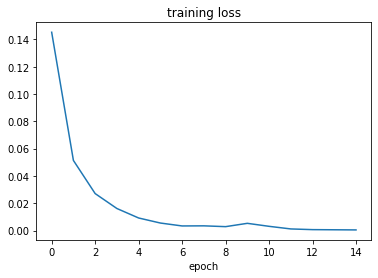

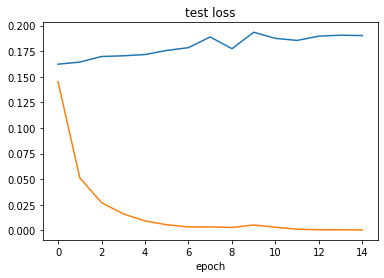

[[404   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   1
    0   0   2   0   0]
 [  0 112  34   0   0   1   0   0   2   2  11   1   1   0   0   0   0  30
   33  18  15   2   0]
 [  1  10  88   0   0   0   4   0   0   0  44   3   2   0   0   1   1   0
   53   4  49   0   1]
 [ 70   0   0  81   0  14   0   4   0  12   0   0   0   2   0   0   0   9
    0   6   0   0   0]
 [ 95   0   0  12  56  13   5   0   2   3   1   0   1   2   0   0   0   2
    1   1   2   0   1]
 [ 92   1   0   5  12  38  19   0   1   0   0   0   0   1   2   0   0  20
    0   5   1   0   1]
 [ 61   0   0   1  30   3  81   0   7   0   0   0   0   0   0   0   0   0
    6   1   4   1   0]
 [  0   4   2   8   0   2   0  23   6  30   0   0   0   0   2   1   3  92
    2  11   6   2   3]
 [  0   0  20   0   1   1   5   0  32   4  30   0   0   0   0   1   1  13
   46   3  34   5   0]
 [  0  15   1   0   0   0   0   3   0  91  13   0   0   0   0   0   0  37
    2  26   7   2   1]
 [  0   5  11   0   0   0   0 

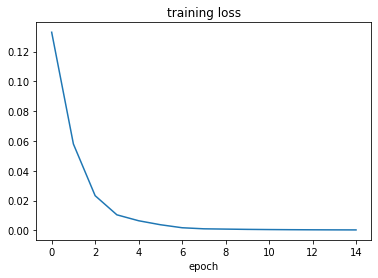

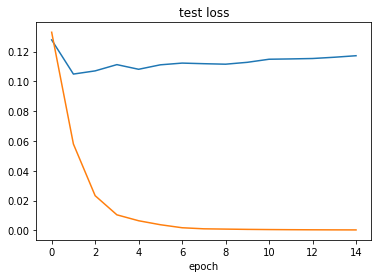

[[382   0   0   0   2   0   2   2   0   0   0   0   0   3   0   0   0   0
    0   0   0   0   0]
 [  0 144  55   0   0   0   0   2   4   9  10   4   4   0   0   1   0   7
    0  11   3   0   0]
 [  0  17 203   0   0   0   0   0   2   3   6   3   4   0   0   1   0   0
    3   5   6   0   0]
 [ 27   1   0  72  13  14   0  10   7  12   7   0   0  14  11   3   0   0
    0   0   0   1   0]
 [  8   1   0   9  94  14   6   2  11   0   2   0   0  27   5   9   3   0
    0   0   0   0   0]
 [ 17   3   1   2  38  84  15  22   2   0   1   3   0   1   1   0   0   0
    0   2   0   0   0]
 [  7   0   5   0  23  14 115   1  15   1   0   1   0   1   1   1   0   0
    3   0   1   0   0]
 [  1   1   3   6   0   5   1  80  34  25   8   0   2   2   3   5   0   3
    0   6   2   4   1]
 [  2   3  24   0   2   0   2   1 110   0  21   0   8   0   1   6   0   0
    2   0   5   0   3]
 [ 11  15   2   3   0   0   0  15  33  70  29   2   4   0   0   2   0   0
    0   5   1   0   0]
 [  1   2  59   0   0   0   0 

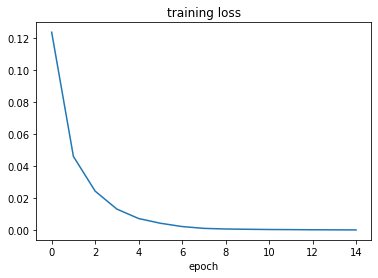

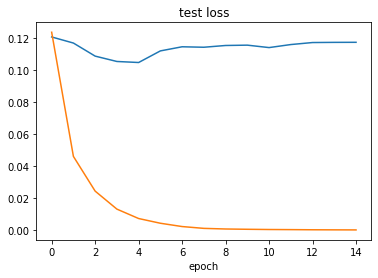

[[385   0   0   0   0   0   0   0   0   3   0   0   0   0   1   0   0   0
    0   0   0   0   0]
 [  1 138  45   0   0   0   0   9  33   5   8   1   1   0   0   1   0   1
    7   1   0   1   0]
 [  0  17 210   0   0   0   0   0  16   0   1   0   1   0   0   0   0   0
    4   0   1   0   1]
 [ 66   0   0  58   4   3   0  41   1  10   1   0   1   0   6   0   0   0
    1   0   0   0   0]
 [106   0   0   9  32   1   1  12  10   0   0   0   9   4   4   0   0   3
    0   0   0   0   0]
 [ 40   0   0   0   4  39  37  19   5   6   0   0   1   0  29   0   0  12
    0   0   0   0   0]
 [  9   0   2   0   4   1 132   0  27   1   8   0   1   0   5   0   1   1
    0   0   0   0   0]
 [  0   1   2   0   0   9   1  88  18  51   5   0   2   0   1   6   1   1
    1   1   3   0   0]
 [  0   0  25   0   0   0   1   1  90   4  40   0   0   0   1   4   1   0
    5   0  17   0   1]
 [  0  12   5   0   0   3   0  30  27  88  13   0   1   1   9   1   0   0
    2   0   0   0   0]
 [  0   0  66   0   0   0   0 

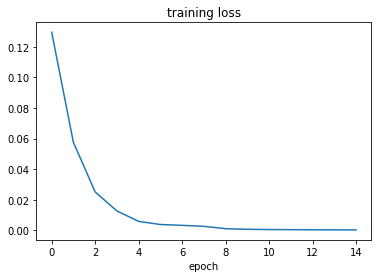

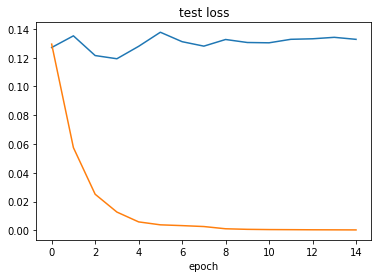

[[384   0   0   2   2   0   0   0   0   0   1   0   0  11   1   0   0   0
    0   1   0   0   0]
 [  3 172  13   0   2   0   0   0  12   7  23   0   0   0   0   0   0   8
   10   2   1   1   0]
 [  1  30 130   0   0   0   0   0  37   0  29   1   1   0   0   0   0   1
   17   2   4   0   0]
 [ 17   0   0  87   6  10   1  27   7  13   0   0   1   7   3  11   1   0
    0   1   0   0   0]
 [  9   0   0   3  64  28   7  16  35   2   0   0   0  12   3   6   3   2
    1   0   0   0   0]
 [  5   1   0   6  62  92   7   2   0   1   0   0   3   8   0   0   0   4
    0   1   0   0   0]
 [  1   1   0   0  42   6 126   1   7   0   0   0   2   0   1   0   0   0
    2   0   0   0   0]
 [  0  16   0  20  38   7   3  56  23  22   0   0   2   0   0   0   0   0
    0   4   0   0   0]
 [  0  21   4   0   8   0   2   2 128   5   9   0   5   0   0   0   1   0
    2   0   3   0   0]
 [  1  48   1   4   4   1   0  28  34  56   1   0   9   0   0   0   0   0
    1   4   0   0   0]
 [  0  17  32   0   0   0   0 

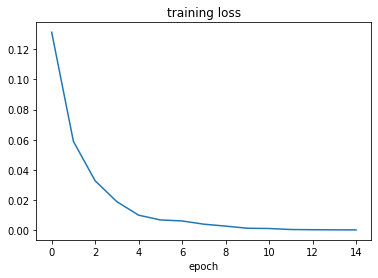

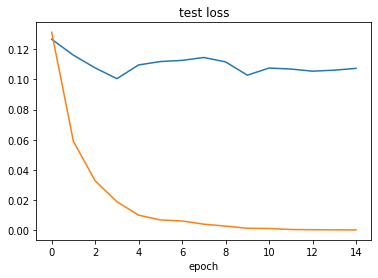

[[399   0   0   1   0   0   0   0   0   0   0   0   2   6   1   0   0   0
    0   0   0   0   0]
 [  0  87  25   0   0   1   0   0   0  85   1   4  15   0   0   1   0  13
    0  25   2   0   0]
 [  0   7 197   0   0   0   0   0   2   7  14   1   8   0   0   0   1   0
    1   2  17   0   1]
 [ 13   0   0 112   3   6   0   5   0  18   0   0   0  37   0   1   0   0
    0   0   0   0   0]
 [ 11   1   0  17  38  18   0  13   0   4   1   0   1  86   1   0   0   0
    0   0   0   3   0]
 [  4   2   0  10  69  68   2   7   0   1   0   0   2  21   9   0   0   0
    0   0   0   0   0]
 [  0   1   0   0  32  28 104   6   0   1   0   0   2  14   2   0   0   0
    0   0   2   0   0]
 [  0   5   0  14   1   6   1  81   0  76   0   0   3   3   1   0   0   1
    0   2   0   0   0]
 [  0  12  25   4   0   1   5  16  63  24  24   1  15   0   0   1   0   0
    0   0   2   0   0]
 [  0   5   0   5   0   1   0   7   2 168   1   0   3   0   2   0   0   0
    0   0   0   0   1]
 [  0   7  26   0   0   0   0 

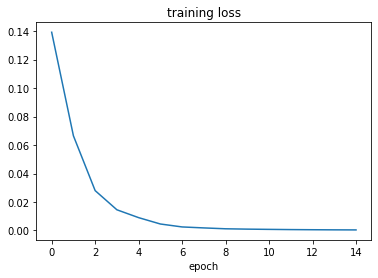

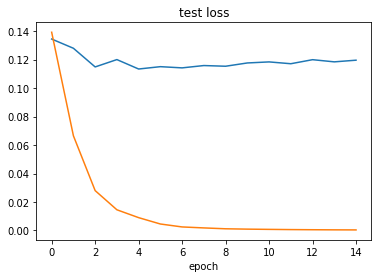

[[404   0   0   1   0   0   0   0   0   3   0   0   0   0   1   0   0   0
    0   0   0   0   0]
 [  0 220   3   0   0   0   0   9   5  10   0   3   2   0   0   0   0   0
    3   1   2   0   1]
 [  0  53 159   0   0   0   0   0  28   0   1   1   1   0   0   0   1   0
   10   0   3   1   0]
 [ 75   0   0  88   1   4   0   5   0   1   0   0   0   4  16   0   0   0
    0   1   0   0   0]
 [ 68   0   0  10  75  17  12   0   0   0   0   0   0  10   1   0   0   0
    0   1   0   0   0]
 [ 58   3   0   2  10 100  13   1   1   1   0   0   0   0   5   0   0   0
    0   1   0   0   0]
 [ 25   1   1   0   8   9 145   0   2   0   0   0   1   0   0   0   0   0
    0   0   0   0   0]
 [  0  18   0  11   3  16   5  30   6  97   0   0   1   2   1   0   0   0
    0   4   0   0   0]
 [  0  19   8   0   1   1  32   2  76  15  24   1   4   0   0   1   3   0
    1   0   5   0   0]
 [  0  47   0  11   0   1   0  26   4 102   1   0   2   0   0   0   0   1
    0   0   0   0   0]
 [  0  32  24   7   1   0   0 

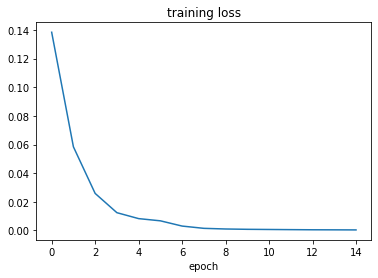

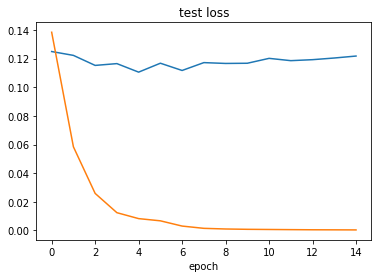

[[405   0   0   0   0   0   0   0   0   1   0   0   0   0   1   3   0   0
    0   0   0   0   0]
 [  0 176  15   1   0   0   0   0   0  36   5   1   0   0   0   0   0  19
    2   0   0   4   0]
 [  0  28 192   0   0   0   0   0   0   0  15   2   0   1   0   0   2   4
   11   0   2   1   0]
 [ 65   0   0  83   4  10   0   4   0   2   1   0   0   0  22   0   0   0
    0   4   0   0   0]
 [ 56   0   0   6  37  26  32   4   0   0   2   0   1   4  16   2   0   0
    1   4   3   0   0]
 [ 66   1   0   2   3  67  36   2   0   1   0   0   0   0   9   1   0   0
    0   4   3   0   0]
 [ 26   3   2   0   1   2 143   0   3   0   0   0   0   0   2   0   0   0
    1   0   9   0   0]
 [  0  17   0  12   1   9   1  69  10  61   5   0   0   0   3   0   0   5
    0   1   0   0   0]
 [  0  23  33   1   1   0   0   4  52  13  52   2   0   3   2   3   1   1
    3   0   0   1   0]
 [  0   9   3   6   0   1   0   2   2 160   8   2   0   0   2   0   0   0
    0   0   0   0   0]
 [  0   9  37   0   0   0   0 

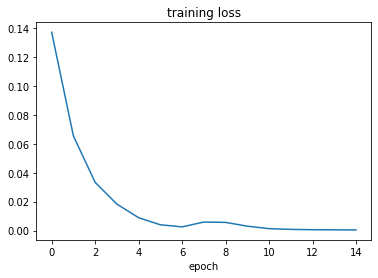

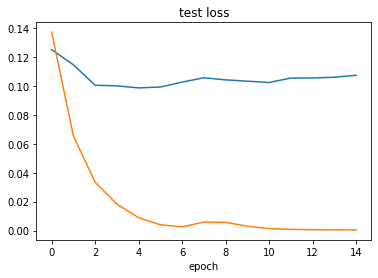

[[403   0   0   1   1   0   1   1   0   2   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0 181   1   1   0   2   0   5   4  34   5   0   3   6   0   0   1   3
    1  11   0   1   0]
 [  0  44 153   0   0   0   0   0   1   0  26   4  10   1   0   0   3   0
    5   1  11   0   0]
 [ 23   0   0  98   1  17   1  43   0   4   0   0   0   0   8   0   0   0
    0   0   0   0   0]
 [ 18   1   0  14  46  60  27  13   2   4   0   0   2   1   6   0   0   1
    0   0   0   0   0]
 [ 13   0   0   3   2 140  16   9   5   1   0   0   0   0   5   0   0   1
    0   0   0   0   0]
 [  4   0   0   0   0  21 148   0  15   0   1   0   2   0   1   0   0   0
    0   0   0   0   0]
 [  0  17   0  11   0  18   0 103   2  36   0   0   1   0   0   1   0   5
    0   0   0   0   0]
 [  0  21   7   0   0   0   2  29  80  16  21   0   6   4   0   2   0   1
    4   0   0   0   0]
 [  0  16   0   7   0   1   0  44   2 122   0   1   0   0   0   0   0   2
    0   0   0   0   0]
 [  0  20   6   0   1   0   0 

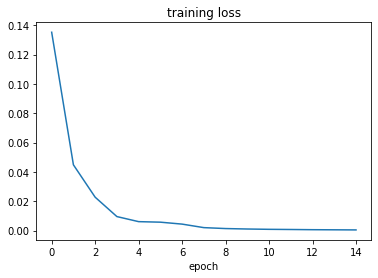

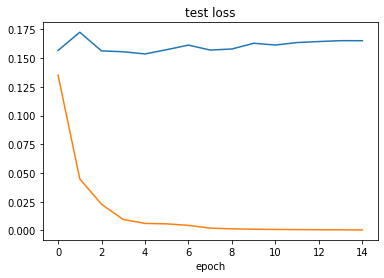

[[404   0   0   0   0   0   0   0   0   0   0   0   0   0   2   0   0   1
    0   1   0   0   0]
 [  0 139  20   0   0   0   0   0   6   3  15   1   0   0   0   0   1  28
   22  13  13   1   0]
 [  0   1 113   0   0   0   9   0   0   0  36   1   0   0   0   0   0   0
   45   0  56   0   0]
 [ 70   0   0  90   2   4   0   2   0   5   0   0   0   1   0   0   0  12
    0   6   0   0   6]
 [100   0   0   8  60   6   3   2   2   0   2   0   1   1   0   0   0   5
    1   5   0   0   1]
 [ 56   0   0   2   3  62   4   3   4   0   0   0   1   0   1   0   0  31
    0  30   0   0   1]
 [ 36   0   0   1  22   5  89   0  20   0   0   0   0   0   0   0   0   3
    1  16   1   1   0]
 [  0   3   2   8   0   2   0  25   7  34   0   0   0   0   0   0   1  99
    0  14   0   0   2]
 [  0   0  14   1   3   1   2   0  53   1  42   0   0   0   0   1   1   5
   46   1  24   1   0]
 [  0  18   1   1   0   0   0   5   3 109   4   0   1   0   0   0   0  29
    2  21   3   1   0]
 [  0   0  18   0   0   0   0 

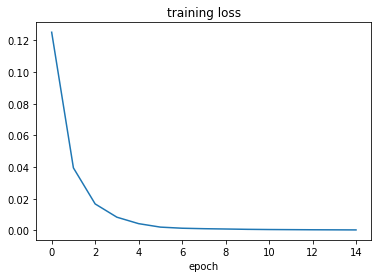

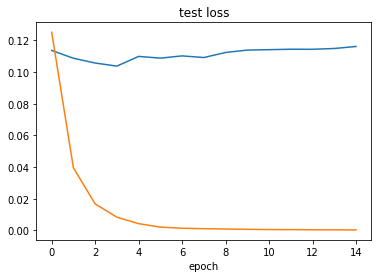

[[388   0   0   0   0   0   0   0   0   0   0   0   0   0   0   3   0   0
    0   0   0   0   0]
 [  0 167  34   0   2   0   0   3   2  13   1   5   4   0   0   1   0  10
    0  11   0   0   1]
 [  1  22 191   0   0   0   0   0   8   3   7   3   5   0   0   1   0   1
    2   7   2   0   0]
 [ 32   0   0  99   3   6   0   3   4  11   5   0   0  10  12   3   0   1
    0   1   0   2   0]
 [ 15   5   0   6  98   8   2   0  14   1   6   0   0  20   7   6   1   0
    0   2   0   0   0]
 [ 40   1   4   0  32  69  11  25   0   1   1   1   0   5   2   0   0   0
    0   0   0   0   0]
 [ 10   1  14   0  26   9  94   2  22   0   2   1   0   2   2   1   0   0
    2   0   0   1   0]
 [  0   1   4  19   0   6   1  89  21  20   8   1   3   1   3   6   0   2
    0   2   2   2   1]
 [  1   5  32   0   2   0   2   1 103   0  23   0   6   0   0   2   0   0
    2   0  11   0   0]
 [  2  19   4  13   1   1   0  29  29  66  14   1   6   0   0   5   0   0
    0   0   1   1   0]
 [  0   1  54   0   2   0   0 

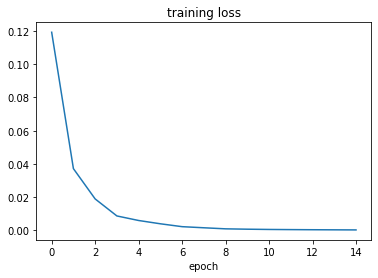

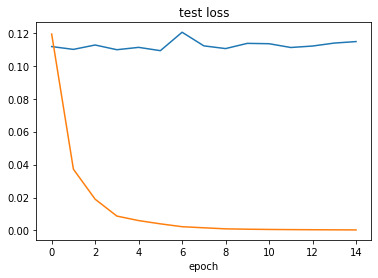

[[385   0   0   0   0   0   0   0   0   2   0   0   0   0   2   0   0   0
    0   0   0   0   0]
 [  1 150  28   0   1   0   1  10  41   4   5   2   1   0   0   0   0   4
    3   0   0   1   0]
 [  0  13 210   0   0   0   0   0  16   0   1   0   0   0   0   0   0   0
   10   0   0   0   1]
 [ 80   0   0  71   0   1   0  26   0   2   0   0   1   1   8   0   0   1
    1   0   0   0   0]
 [120   0   0   1  39   2   0   7  13   0   0   0   1   2   2   0   0   4
    0   0   0   0   0]
 [ 80   0   0   1   1  36  24  12   2   6   0   0   0   0  20   0   0  10
    0   0   0   0   0]
 [ 20   0   4   0   1   0 106   1  26   1   9   0   2   0   6   0   0   0
   13   0   3   0   0]
 [  0   3   0   0   0   5   1 111   8  46   1   0   5   0   0   3   3   1
    1   2   1   0   0]
 [  0   0  34   0   4   0   2   0  61   2  27   0   7   0   0   0   0   0
    8   0  44   0   1]
 [  0  14   1   1   0   0   0  51  27  78   9   1   1   0   1   4   1   0
    2   0   0   0   1]
 [  0   0  67   0   1   0   0 

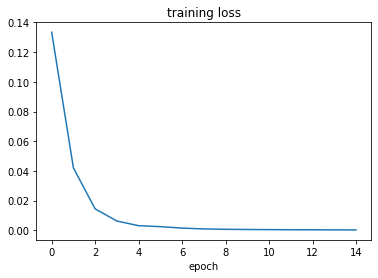

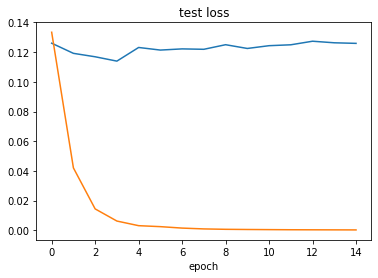

[[384   0   0   3   0   0   0   0   0   0   0   0   0  13   0   1   0   0
    1   0   0   0   0]
 [ 10 138  29   0   0   6   1   0  13   4  32   0   0   0   0   0   0   8
    6   6   0   1   0]
 [  9  16 181   0   0   0   0   0  14   0  19   0   0   0   0   0   0   0
   10   1   3   0   0]
 [  8   0   0  92  11   4   0  46   2   8   1   0   2   7   2   6   2   1
    0   0   0   0   0]
 [ 20   0   0   3  71  15   0  12  55   0   0   0   2   3   2   0   5   0
    3   0   0   0   0]
 [  8   0   0   3  57 103   4   3   1   1   0   0   2   4   0   0   0   5
    1   0   0   0   0]
 [  4   0   1   0  41  17 106   0  10   0   0   0   2   0   1   0   0   1
    6   0   0   0   0]
 [  0   4   1  18  48  16   1  46  26  23   1   0   1   1   0   0   0   1
    2   1   1   0   0]
 [  0   8  16   1   4   1   4   2 132   0  12   0   5   0   0   0   0   1
    0   0   4   0   0]
 [  0  44   2  19   5   7   2  18  25  50   2   0  12   0   0   0   0   3
    0   0   3   0   0]
 [  0   7  50   0   0   0   0 

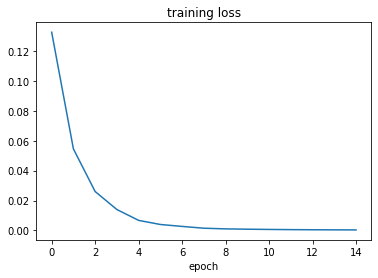

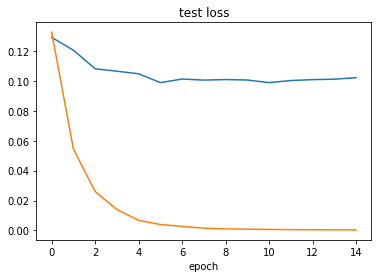

[[400   0   0   0   0   0   0   0   0   0   0   0   2   6   1   0   0   0
    0   0   0   0   0]
 [  1 106  13   0   0   2   0   0   0  76   5   2  20   0   0   1   0  18
    2  11   1   0   1]
 [  0   1 200   0   0   0   0   0   3   3  17   0   8   0   0   0   1   0
    9   0  16   0   0]
 [  7   0   0 119   2   7   0   7   0  26   0   0   0  19   1   1   0   6
    0   0   0   0   0]
 [ 10   0   0  31  39  15   5  11   0   8   6   0   4  59   2   1   0   0
    1   0   0   2   0]
 [  6   7   0  16  45  75   1   1   0   9   0   0   2  22   8   0   0   1
    0   2   0   0   0]
 [  1   0   1   1  21  12 122   5   8   1   0   0   4  11   2   0   2   0
    1   0   0   0   0]
 [  0   3   0  26   1   7   0  81   0  61   0   0   9   3   1   0   0   1
    0   1   0   0   0]
 [  0   3  32   3   1   4   5  14  66  20  24   0  15   0   2   0   0   1
    2   0   1   0   0]
 [  0   5   0   7   0   1   0   9   1 159   0   0   6   0   4   0   1   2
    0   0   0   0   0]
 [  0   4  20   0   0   0   0 

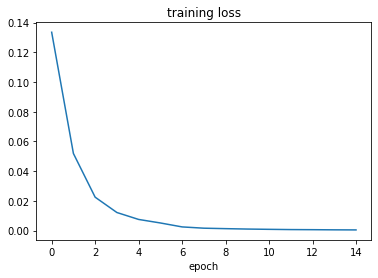

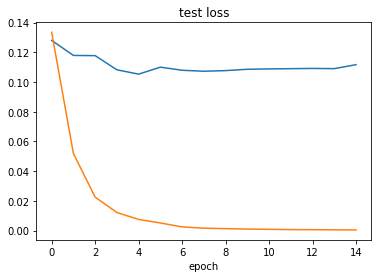

[[406   0   0   0   0   0   0   0   0   1   0   0   0   0   1   0   0   0
    0   1   0   0   0]
 [  0 215   5   0   0   1   0  11   3   6   0   1   7   0   0   0   0   1
    5   1   2   0   1]
 [  0  10 201   0   0   0   0   0  30   0   0   0   4   0   0   0   0   0
    9   0   4   0   0]
 [ 74   0   0 103   0   5   1   6   0   0   0   0   0   2   4   0   0   0
    0   0   0   0   0]
 [ 75   0   0  10  82   6   8   3   0   1   0   0   4   1   2   0   0   0
    0   2   0   0   0]
 [ 61   5   0   1   4 112   5   3   0   1   0   0   1   0   2   0   0   0
    0   0   0   0   0]
 [ 32   2   2   0   2  11 141   0   2   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0  18   0   3   0  10   2  54   0 102   1   0   3   1   0   0   0   0
    0   0   0   0   0]
 [  0   5  32   0   1   0  17   1  70  12  38   1   8   0   0   1   0   0
    2   0   5   0   0]
 [  0  41   0   2   0   0   0  49   0 100   0   0   3   0   0   0   0   0
    0   0   0   0   0]
 [  0   4  51   0   0   0   0 

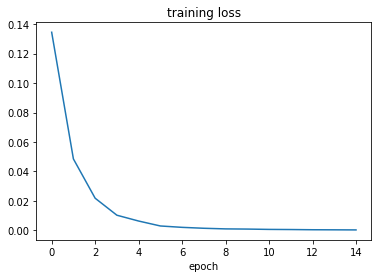

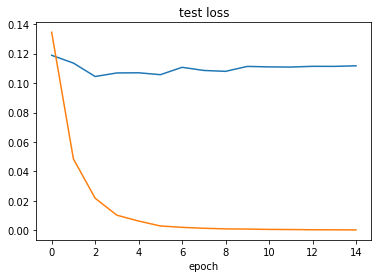

[[405   0   0   1   0   0   0   0   0   0   0   0   0   0   1   3   0   0
    0   0   0   0   0]
 [  0 185   6   0   0   0   0   2   1  34   5   1   0   0   0   0   0  15
    2   0   0   8   0]
 [  0  22 213   0   0   0   0   0   0   0   6   0   0   0   0   0   0   1
   14   0   0   2   0]
 [ 41   0   0  91   8  11   0   2   0   0   1   0   0   0  31   2   0   0
    0   8   0   0   0]
 [ 68   0   0   1  56   7  29   3   0   0   1   0   0   0  13   2   0   0
    0   5   7   2   0]
 [ 76   4   0   2   2  64  22   4   1   0   0   0   0   0  13   0   0   0
    0   7   0   0   0]
 [ 44   4   1   0   4   2 129   0   2   0   0   0   0   0   1   0   0   0
    1   0   4   0   0]
 [  0  16   0   9   2   3   2  76   8  69   0   0   1   0   3   1   0   4
    0   0   0   0   0]
 [  0  23  22   0   4   0   0   3  71  12  54   0   0   0   0   3   0   0
    2   0   1   0   0]
 [  0  10   2   7   0   0   0   7   1 158   8   0   0   0   1   0   0   1
    0   0   0   0   0]
 [  0   3  36   0   1   0   0 

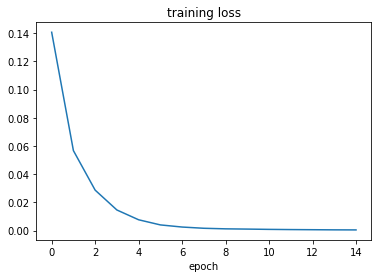

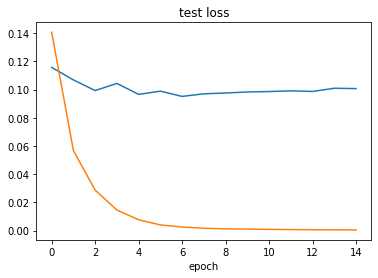

[[405   0   0   0   0   0   0   3   0   0   0   0   0   0   0   1   0   0
    0   0   0   0   0]
 [  0 162   1   2   0   4   0   6   4  45   3   0   7   3   0   0   2   2
    0  17   0   1   0]
 [  0  19 183   0   0   0   0   0   2   0  30   1   6   0   0   0   0   0
    6   2  10   0   0]
 [ 27   0   0  96   1  14   3  35   0   3   0   0   0   0  16   0   0   0
    0   0   0   0   0]
 [ 32   0   0  15  56  41  24  16   1   2   0   0   3   0   3   0   0   2
    0   0   0   0   0]
 [ 17   0   0   3   1 149  11   5   7   1   0   0   0   0   1   0   0   0
    0   0   0   0   0]
 [  9   0   1   0   1  15 145   1  18   0   0   0   2   0   0   0   0   0
    0   0   0   0   0]
 [  0   5   0   7   0  11   0 122   3  43   0   0   1   0   0   0   0   2
    0   0   0   0   0]
 [  0  12  11   3   2   0   2  18  83  12  24   0  13   0   0   0   0   0
   13   0   0   0   0]
 [  0   4   0   6   0   3   0  44   3 130   0   0   3   0   0   0   0   2
    0   0   0   0   0]
 [  0   5   4   3   2   0   0 

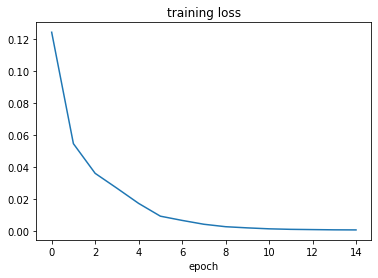

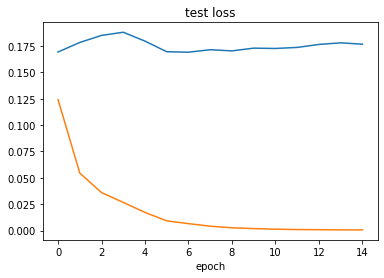

[[403   0   0   0   0   0   0   0   0   0   0   0   0   1   1   0   0   2
    0   1   0   0   0]
 [  0 113  28   0   0   0   3   2   3   8  24   3   1   0   0   0   0  28
   25   6  16   2   0]
 [  0  11  96   0   0   0   3   0   0   0  54  10   1   0   0   0   0   0
   25   0  61   0   0]
 [ 71   0   0  73   0   4   0   7   0   8   1   0   0   1   0   0   0  11
    0  20   1   1   0]
 [ 93   0   0   6  62   0   3   1   4   0   8   0   0   0   0   0   0   4
    2  13   0   1   0]
 [ 60   1   0  11   4  30   6   2   5   1   0   0   1   0   0   0   0  29
    0  48   0   0   0]
 [ 32   0   0   2  26   1  61   0  29   0   0   0   2   0   0   0   0   3
    4  34   1   0   0]
 [  0   3   0   4   0   0   1  24  13  37   1   0   0   0   0   3   3  85
    3  20   0   0   0]
 [  0   1  10   0   0   1   5   1  78   7  17   0   0   0   0   0   1   3
   27  11  28   6   0]
 [  0  22   1   0   0   0   1   6   6  93   8   0   1   0   0   0   0  30
    3  18   8   1   0]
 [  0   1  16   0   0   0   0 

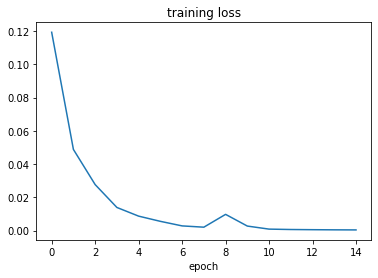

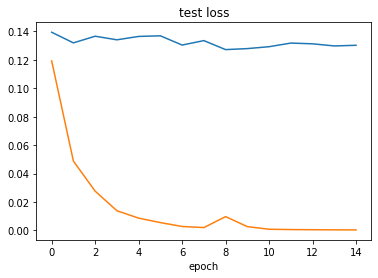

[[389   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   0   0
    0   0   0   0   0]
 [  0 184  30   0   0   0   0   7   0   6   1   9   4   0   0   3   0   1
    0   8   0   1   0]
 [  0  36 173   0   0   0   0   0   4   3   9   8   8   0   0   1   0   0
    1   8   1   0   1]
 [ 20   6   0  78  10   8   1  11   1  10  12   0   0   9   3   9   0   0
    3   3   0   8   0]
 [ 21   5   0  16  80   0   0   3   4   0   4   0   0   5   7  33   1   0
    8   1   0   3   0]
 [ 32   2   4   3  13  38  33  46   4   5   1   1   0   1   4   1   0   0
    0   4   0   0   0]
 [  4   0  10   1  25   4  88   4  37   1   3   0   0   0   4   1   0   0
    4   1   2   0   0]
 [  0   8   0  18   0   2   2  83  23  21   5   0   1   0   1   8   0   2
    0   2   4  11   1]
 [  0  13  10   0   2   0   9  11  77   0  36   0   5   0   3  11   0   0
    1   0   8   3   1]
 [  0  26   2  12   0   4   1  35  13  54  18   1   7   0   0  11   0   1
    0   4   0   2   1]
 [  0   6  46   0   0   0   0 

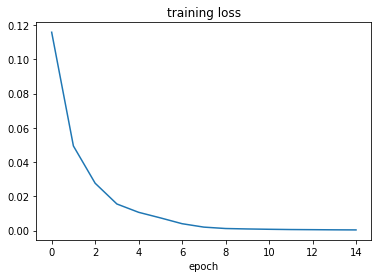

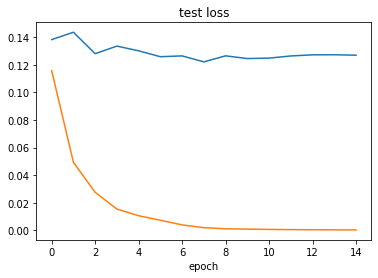

[[385   0   0   0   0   1   0   0   0   2   0   0   0   0   0   0   1   0
    0   0   0   0   0]
 [  1 154   6   0   0   0   1  10  47  17   3   1   1   1   0   3   1   4
    0   2   0   0   0]
 [  0  15 167   0   0   0   0   0  37   0  18   0   5   0   0   2   0   0
    1   0   1   1   4]
 [ 70   0   0  62   3   3   0  37   1   1   8   0   2   1   2   0   1   0
    0   0   0   1   0]
 [ 93   0   0   1  38   1   1   5  26   0  11   0   5   4   2   0   0   2
    0   0   0   2   0]
 [ 40   0   0   1   1  28  51  18  18  12   5   0   0   0   9   0   0   5
    0   0   4   0   0]
 [ 12   0   1   0   1   1  94   0  38   9  28   0   0   0   0   0   1   0
    0   0   6   1   0]
 [  0   0   0   0   2   3   1  89  25  47   8   1   3   0   0   5   1   0
    0   2   4   0   0]
 [  0   1  16   0   3   0   2   1  76   7  31   0  13   0   0   0   1   0
    0   0  28   0  11]
 [  0   5   0   1   0   0   0  49  23  93   8   1   2   1   1   3   0   0
    0   3   0   1   1]
 [  0   0  39   0   7   0   0 

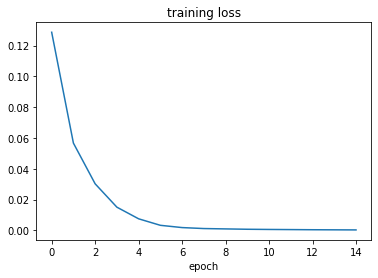

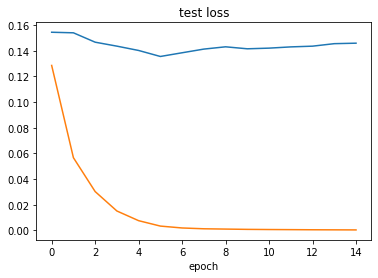

[[389   0   0   1   1   0   2   0   0   0   0   0   0   8   0   1   0   0
    0   0   0   0   0]
 [  8 165  31   0   2   0   0   6   2   8  15   0   0   0   0   0   0  11
    3   3   0   0   0]
 [  3  35 160   0   0   0   0   0  15   0  32   4   0   0   0   0   0   2
    2   0   0   0   0]
 [ 10   3   0  57  32   3   2  41  31   1   0   0   1   1   0   4   4   2
    0   0   0   0   0]
 [  9   0   1   2  64  15   1  11  62   0   2   0   3   4   0   1   6   0
    9   0   0   1   0]
 [  2   5   0   1  79  69  10   5   9   2   0   0   1   0   0   0   0   5
    2   1   1   0   0]
 [  4   3   2   0  45  14  69   3  24   0   7   0   4   0   2   0   0   0
   11   0   0   1   0]
 [  0  22   0  12  51   5   3  50  33   5   6   0   1   0   0   0   0   0
    0   1   2   0   0]
 [  0   7  25   0  10   1   9   9  99   1  18   0   7   0   0   0   0   0
    0   0   4   0   0]
 [  0  50   4   6   6   4   2  58   7  41   6   0   6   0   0   0   0   0
    0   0   1   1   0]
 [  0  11  62   0   0   0   5 

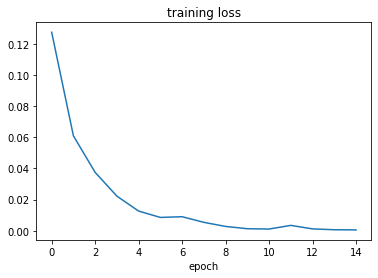

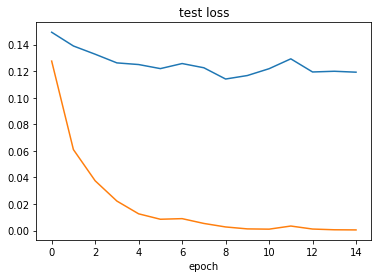

[[400   0   0   0   0   1   0   0   0   0   0   0   1   6   0   0   0   0
    0   0   1   0   0]
 [  0 157  15   0   0   0   0   0   0  46   1   5   6   0   0   0   0  13
    0   7   8   0   1]
 [  0  10 159   0   0   0   0   0   2  12  13   9  31   0   0   0   0   1
    0   0  11   3   7]
 [  7   0   0 133   6   9   1   7   0  11   0   0   3  16   0   2   0   0
    0   0   0   0   0]
 [  8   1   0  31  50   6   1  19   0  20   0   0   5  48   0   2   0   0
    0   1   1   1   0]
 [  7   2   0  35  54  60  17  12   0   1   0   0   1   3   2   0   0   1
    0   0   0   0   0]
 [  1   0   0  12  37  12  93  24   2   3   0   0   3   1   0   0   1   0
    0   0   3   0   0]
 [  0  15   0  21   0   8   0  85   0  59   0   0   3   1   0   0   0   0
    0   2   0   0   0]
 [  0  17  11   1   0   3   3  30  56  37  11   0  18   0   1   1   0   0
    1   0   2   0   1]
 [  0   5   1   7   0   0   0  13   4 149   1   2   1   0   0   3   3   1
    1   0   4   0   0]
 [  0   2  15   0   0   0   0 

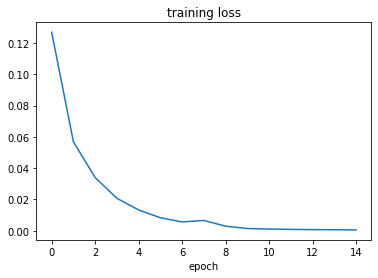

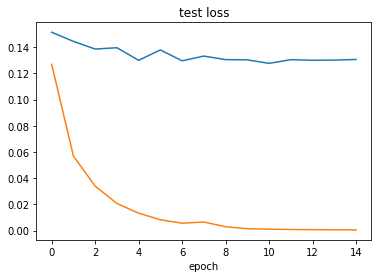

[[407   0   0   0   1   0   0   0   0   0   0   0   0   0   1   0   0   0
    0   0   0   0   0]
 [  0 228   0   0   0   0   0   6  11   3   0   0   0   0   1   2   0   1
    2   4   0   0   1]
 [  0  52 137   0   0   0   0   1  43   0   0   0  12   0   0   1   0   0
    4   0   6   1   1]
 [ 74   2   0  87   2   5   2   9   0   4   0   0   1   6   0   0   0   0
    0   0   3   0   0]
 [ 72   0   0  11  56   7   8   1   0   1   0   0   5  22   2   0   0   0
    0   0   9   0   0]
 [ 48  12   0   1   3  99  18   6   0   5   0   0   0   0   3   0   0   0
    0   0   0   0   0]
 [ 34   7   5   0   0  11 128   1   2   0   0   0   0   0   0   0   0   0
    0   0   4   0   0]
 [  0  26   0   1   2   7   2  48   3 100   0   0   1   2   1   0   0   0
    0   0   1   0   0]
 [  0  18  15   0   0   1   8   5  63  21  49   0   4   0   0   1   4   0
    3   0   0   0   1]
 [  0  57   0   3   0   1   0  40   3  88   1   0   0   0   1   1   0   0
    0   0   0   0   0]
 [  0  32  14   2   0   0   0 

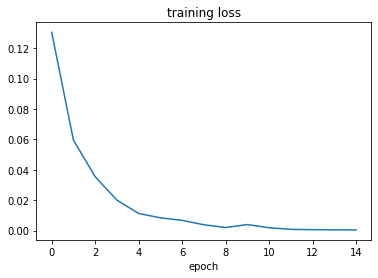

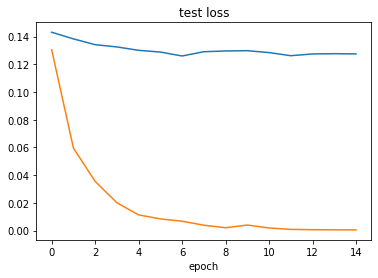

[[403   0   0   0   0   1   1   0   0   0   0   0   0   0   2   3   0   0
    0   0   0   0   0]
 [  0 188   1   0   0   0   0   0   0  44   0   1   0   0   0   2   1  17
    2   0   0   3   0]
 [  1  46 160   0   0   0   0   0   0   2  14   3   3   0   0   2   9   2
    9   0   0   7   0]
 [ 33   0   0  77   3  30   9   3   0   1   1   0   0   0  16   4   0   0
    0  18   0   0   0]
 [ 59   0   0   5  41  20  29   0   0   2   1   0   0   0  15   5   0   0
    1  10   6   0   0]
 [ 56   2   0   5   0  71  40   5   1   1   0   0   0   0   6   2   0   0
    0   6   0   0   0]
 [ 42   2   3   2   2   9 112   0  11   1   0   0   0   0   1   1   0   0
    2   0   4   0   0]
 [  0  17   0  12   1  17   4  65  11  59   2   0   0   1   4   0   0   1
    0   0   0   0   0]
 [  0  24  13   1   1   1   5   3  63  21  43   1   2   0   2   3   4   3
    3   0   1   1   0]
 [  0  13   0   5   0   1   0   4   3 158   3   1   0   0   2   2   1   1
    0   0   0   1   0]
 [  0   5  22   1   1   0   0 

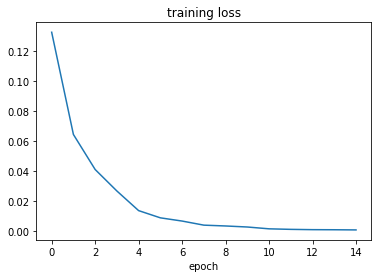

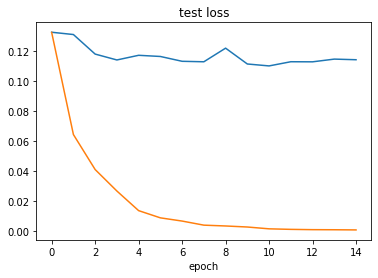

[[405   0   0   0   1   0   0   0   2   0   0   0   0   0   0   1   0   0
    0   0   0   0   0]
 [  0 197   0   0   0   0   0   4   2  37   0   0   4   1   0   0   0   1
    0  11   2   0   0]
 [  0  25 164   0   0   0   0   0   0   2  25   4  24   0   0   0   0   1
    4   1   9   0   0]
 [ 25   0   0  86   3  37   2  26   0   3   0   0   0   0  13   0   0   0
    0   0   0   0   0]
 [ 31   1   0  11  51  34  25   7   1   8   5   0   1   0  18   0   0   2
    0   0   0   0   0]
 [ 15   0   0   0   2 136   8  12  16   1   0   0   0   0   5   0   0   0
    0   0   0   0   0]
 [ 13   0   1   0   1  19 115   7  31   1   0   0   3   0   1   0   0   0
    0   0   0   0   0]
 [  0   7   0   6   0  13   2 121   1  40   0   0   3   0   0   1   0   0
    0   0   0   0   0]
 [  0  17   9   3   0   0   5  27  68  21  27   0   9   0   0   0   0   1
    6   0   0   0   0]
 [  0  16   0   2   0   1   0  28   4 135   0   0   6   0   1   0   0   2
    0   0   0   0   0]
 [  0  14   7   0   0   0   0 

In [4]:
in_ch=48
num_class=23
self_channel=[0,1,10,11,20,21,30,31]
par_vit={'dim':512,'depth':6,'heads':16,'mlp_dim':32,'dropout':0.1,'emb_dropout':0.1,'n_epoch':15,'learning_rate':1e-4};

modelVer='v1_per8_train_on_one'

def gen_trans_model(X_all,y_all,opt,per_test,FeatType):
  import torch
  torch.cuda.empty_cache()

  if __name__ == '__main__':
      
      transform = ToTensor()
      batchsize_train = 16

      # folds=RepeatedStratifiedKFold(n_splits=5, n_repeats=1,random_state=100).split(X_all,y_all)
      # folds=StratifiedGroupKFold(n_splits=7).split(X_all,y_all,perNum_all_per) 
      # test_ind_all=[]
      # train_ind_all=[]
      # for train_index, test_index in folds:
      #   test_ind_all.append(test_index)
      #   train_ind_all.append(train_index)
      # n_sel=2
      
      trn_ind=np.where(perNum_all_per==per_test)[0]
      tst_ind=np.where(perNum_all_per!=per_test)[0]

      X_train=X_all[trn_ind] 
      X_test=X_all[tst_ind]
      y_train=y_all[trn_ind] 
      y_test=y_all[tst_ind]

      train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), batch_size=batchsize_train,shuffle=True)
      batchsize_test = 16
      test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), batch_size=batchsize_test, shuffle=False)


      (unique, counts) = np.unique(perNum_all_per[trn_ind], return_counts=True)
      frequencies = np.asarray((unique, counts)).T
      print(frequencies)
      (unique, counts) = np.unique(perNum_all_per[tst_ind], return_counts=True)
      frequencies = np.asarray((unique, counts)).T
      print(frequencies)
      #hyperparameter definition    
      learning_rate = par_vit['learning_rate']  #学习的速率 越小越精细
      momentum = 0.1
      random_seed=1
      torch.backends.cudnn.enabled = False
      torch.manual_seed(random_seed)     #设定随机数种子为固定值
      
      train_loss_epoch = []
      test_acc_epoch =[]
      total_acc_epoch = []
      

   

      network = ViT(
      image_size = opt['image_size'],
      patch_size = opt['patch_size'],
      num_classes =num_class,
      dim = par_vit['dim'],
      depth = par_vit['depth'],
      heads = par_vit['heads'],
      mlp_dim = par_vit['mlp_dim'],
      dropout = par_vit['dropout'],
      emb_dropout = par_vit['emb_dropout'],
      channels = in_ch
      ).cuda()
   
      #training
      optimizer = optim.Adam(network.parameters(), lr=learning_rate)
      #optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
      

      #network.train()
      Training_Loss = []
      Test_Loss = []
      start_time = time.time()
      criterion = nn.CrossEntropyLoss()
      #criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1, 3]).cuda())
      for epoch in range(par_vit['n_epoch']):   # loop over the dataset multiple times
          train_loss = 0
          for X, Y in train_loader:
              # X = X.view(-1,1,X.shape[2],X.shape[3]).cuda()
              X = X.float().cuda()  
              Y = Y.long().view(-1, ).cuda() 
              current_batchsize = X.shape[0]
              optimizer.zero_grad()
              output = network(X)
              loss = criterion(output,Y)
              train_loss = train_loss + loss.item()
              loss.backward()                     #calculate the gradient decent
              optimizer.step()                    #update the weight
              
            





          test_loss = 0
          correct = 0
          total = 0
          test_y= []
          test_y_p = []
     
          with torch.no_grad():        
              # X = X.view(-1,X.shape[1],X.shape[2])
              # X = X.float()         
              for X, Y in test_loader:
                  X = torch.Tensor(X).cuda()
                  Y = torch.Tensor(Y).long().view(-1, ).cuda()
                  images, labels = X, Y
                  # calculate outputs by running images through the network
                  outputs = network(images)
                  loss = criterion(outputs,Y)
                  test_loss = test_loss + loss.item()

                  # the class with the highest energy is what we choose as prediction
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()
                  
                  for i in range(len(labels)):
                    test_y.append(labels[i])
                    test_y_p.append(predicted[i])
          
          #print('Accuracy of test cases: %d %%' % (100 * correct / total))
  

          Training_Loss.append(train_loss/len(train_loader.dataset))
          Test_Loss.append(test_loss/len(test_loader.dataset))
          if epoch%2==0:
              print(train_loss/len(train_loader.dataset))
              print(test_loss/len(test_loader.dataset))
        
      FeatName=['stft','stft2','cwt','cwt2','cwt3']        
      PATH='/content/drive/My Drive/Colab Notebooks/RFMG/data/'+"/model_all_vit/"+modelVer+"/"+FeatName[FeatType]+"_trn_"+str(per_test)+".pt"
      torch.save(network.state_dict(), PATH)
      # train_loss_epoch.append(Training_Loss[-1])
      # training_time=time.time()-start_time
      #print('total training time is',training_time)
      
      plt.figure()
      plt.plot(Training_Loss)
      plt.title("training loss")
      plt.xlabel("epoch")
      plt.show()

      plt.figure()
      plt.plot(Test_Loss)
      plt.title("test loss")
      plt.xlabel("epoch")
      plt.plot(Training_Loss)
      plt.show()

  test_y_p=torch.FloatTensor(test_y_p)
  test_y=torch.FloatTensor(test_y)
  test_y_p=np.array(test_y_p.cpu())
  test_y=np.array(test_y.cpu())
  test_y2=np.stack((test_y, test_y_p))



  cm=confusion_matrix(test_y, test_y_p)
  acc=accuracy_score(test_y, test_y_p)
  print(cm,acc)
  return cm,acc,test_y2

#cm,acc,test_y2=test(feature_2d_stft,label_all,{'net':'stft'})
#cm,acc,test_y2=test(feature_all,label_all,{'net':'1d'})
# cm1,acc1,test_y1=test(feature_2d_stft[:,:32,:,:],label_all,{'net':'stft'})

# ind=np.where(perNum_all_per==6)[0]
cm1=[]
acc1=[]
test_y1=[]
cm2=[]
acc2=[]
test_y2=[]
cm3=[]
acc3=[]
test_y3=[]

for i in range(1,int(np.max(perNum_all_per))+1):


  cm,acc,test_y=gen_trans_model(feature_stft_per,label_all_per,{'image_size':56,'patch_size':7},i,0)
  cm1.append(cm)
  acc1.append(acc)
  test_y1.append(test_y)
for i in range(1,int(np.max(perNum_all_per))+1):


  cm,acc,test_y=gen_trans_model(feature_stft2_per,label_all_per,{'image_size':40,'patch_size':5},i,1)
  cm1.append(cm)
  acc1.append(acc)
  test_y1.append(test_y)
for i in range(1,int(np.max(perNum_all_per))+1):


  cm,acc,test_y=gen_trans_model(feature_cwt_per,label_all_per,{'image_size':125,'patch_size':5},i,2)
  cm1.append(cm)
  acc1.append(acc)
  test_y1.append(test_y)

# for i in range(1,int(np.max(perNum_all_per))+1):
#   cm,acc,test_y=gen_trans_model(feature_cwt2_per,label_all_per,{'image_size':125,'patch_size':5},i,3)
#   cm2.append(cm)
#   acc2.append(acc)
#   test_y2.append(test_y)

# for i in range(1,int(np.max(perNum_all_per))+1):
#   cm,acc,test_y=gen_trans_model(feature_cwt3_per,label_all_per,{'image_size':125,'patch_size':5},i,4)
#   cm3.append(cm)
#   acc3.append(acc)
#   test_y3.append(test_y)
parameter_vit=np.array(list(par_vit.items()));
# np.savez_compressed("/content/drive/My Drive/Colab Notebooks/RFMG/data/model_all_vit/"+modelVer+"/npyFile/vit_stft1_2_trans_model.npz",\
#                   cm1=cm1,acc1=acc1,\
#              cm2=cm2,acc2=acc2,\
        
#                   parameter_vit=parameter_vit)